In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer, Conv1D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
df = pd.read_csv('sample-pr.csv')
df.head()

,Date,StoreId,StoreName,StoreBillingSoftwareName,RegionId,RegionName,RetailerId,RetailerName,RetailerAddress1,RetailerAddress2,...,StoreProductMRP,StoreProductPTS,OrderLineItemScheme,OrderLineItemPTR,OrderLineItemHiddenPTR,OrderedBy,Free,ActualFreeReceived,OrderAmount,OrderQuantity
0,2019-04-01 00:00:00,17,Nitin Agency,NewMedica,1,Pune,2947,jayshree medico,"4B1kamdhenu estate,hadpsar",NaN,...,76.9,49.44,NaN,54.93,54.93,Self,0,0,164.79,3
1,2019-04-01 00:00:00,1999,"SAI DISTRIBUTOERS, Sadashiv Peth",Dava,1,Pune,39861,Kishor medical and general stores,17/18 garade wada aundh gaon pune7,NaN,...,33.1,0.00,NaN,23.64,0.00,Salesman,0,0,47.28,2
2,2019-04-01 00:00:00,1999,"SAI DISTRIBUTOERS, Sadashiv Peth",Dava,1,Pune,6358,Jai hind chemist & druggist,Dhanshree hight Aundh,NaN,...,33.1,0.00,NaN,23.64,0.00,Salesman,0,0,47.28,2
3,2019-04-01 00:00:00,76,Swastik Medical Store,Care,1,Pune,21286,ishwar medical,"292/4auerlia Square,C Bold,Shop no.8,Pancard C...",NaN,...,33.1,0.00,NaN,23.64,23.64,Self,0,0,47.28,2
4,2019-04-01 00:00:00,76,Swastik Medical Store,Care,1,Pune,110,Maharashtra chemist n druggist,"shop no.-15, bwing, salini res.,karve nagar",NaN,...,33.1,0.00,NaN,23.64,23.64,Self,0,0,94.56,4


In [4]:
df = df[['Date', 'StoreProductName', 'OrderQuantity']]
df.head()

,Date,StoreProductName,OrderQuantity
0,2019-04-01 00:00:00,ATEN (H) 25MG,3
1,2019-04-01 00:00:00,ATEN 25,2
2,2019-04-01 00:00:00,ATEN 25,2
3,2019-04-01 00:00:00,ATEN 25 MG,2
4,2019-04-01 00:00:00,ATEN 25 MG,4


In [5]:
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('STAMLO') != -1, 'STAMLO', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('NUMLO') != -1, 'S-NUMLO', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('GLUCONORM') != -1, 'GLUCONORM', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('TELMA') != -1, 'TELMA', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('ATEN') != -1, 'ATEN', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('GLADOR') != -1, 'GLADOR', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('GLIMISAVE') != -1, 'GLIMISAVE', df['StoreProductName'])
df['StoreProductName'] = np.where(df['StoreProductName'].str.find('TELMIKIND') != -1, 'TELMIKIND', df['StoreProductName'])
df = df[df['StoreProductName'].str.find('GLIMISTAR') == -1]
df.head()

,Date,StoreProductName,OrderQuantity
0,2019-04-01 00:00:00,ATEN,3
1,2019-04-01 00:00:00,ATEN,2
2,2019-04-01 00:00:00,ATEN,2
3,2019-04-01 00:00:00,ATEN,2
4,2019-04-01 00:00:00,ATEN,4


In [6]:
df['StoreProductName'].value_counts()

TELMA        107303
TELMIKIND     76418
STAMLO        54165
ATEN          20782
GLUCONORM     20267
GLIMISAVE      8470
S-NUMLO        7270
GLADOR         2315
Name: StoreProductName, dtype: int64

In [7]:
df['Date'] = df['Date'].str.split(' ', n = 1, expand = True)[0]
df.head()

,Date,StoreProductName,OrderQuantity
0,2019-04-01,ATEN,3
1,2019-04-01,ATEN,2
2,2019-04-01,ATEN,2
3,2019-04-01,ATEN,2
4,2019-04-01,ATEN,4


In [8]:
df1 = df.groupby(['StoreProductName'])

In [9]:
dfs = {}
for i in df['StoreProductName'].unique():
    dfs[i] = df1.get_group(i)
    dfs[i] = dfs[i].drop('StoreProductName', axis=1)
    dfs[i] = dfs[i].groupby('Date').sum()

In [10]:
series_dict, time_dict = {}, {}
for i in dfs.keys():
    series_dict[i] = dfs[i].to_numpy()
    series_dict[i] = series_dict[i].reshape(-1)
    time_dict[i] = np.arange(len(dfs[i]))

In [11]:
def plot_series(time, series, title=None, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

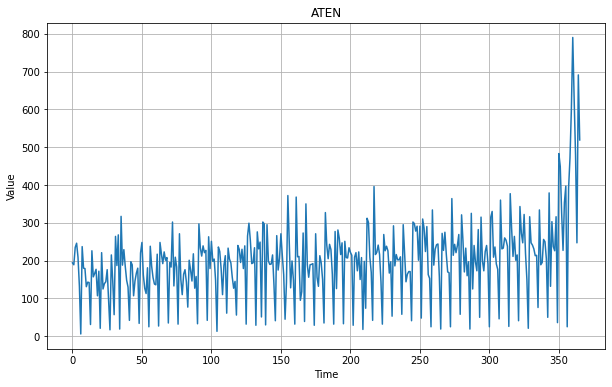

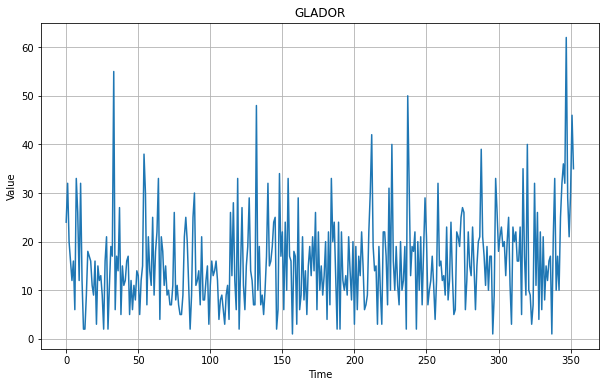

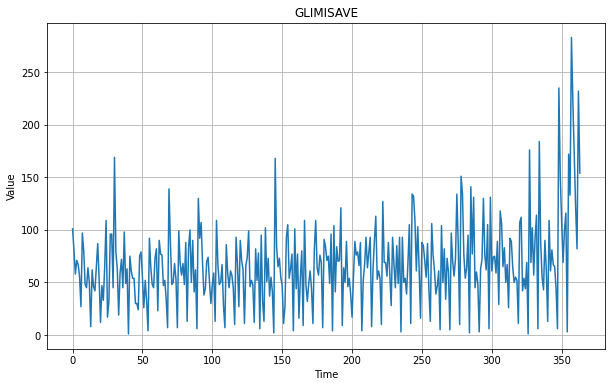

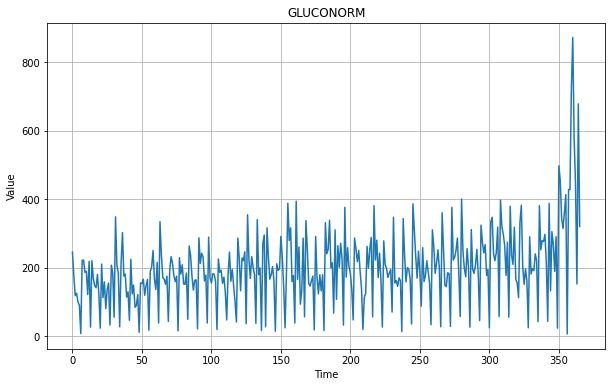

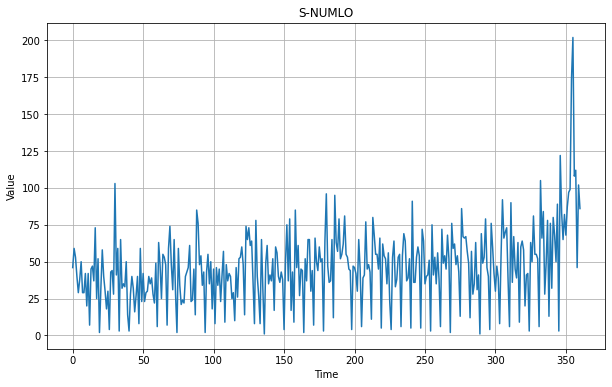

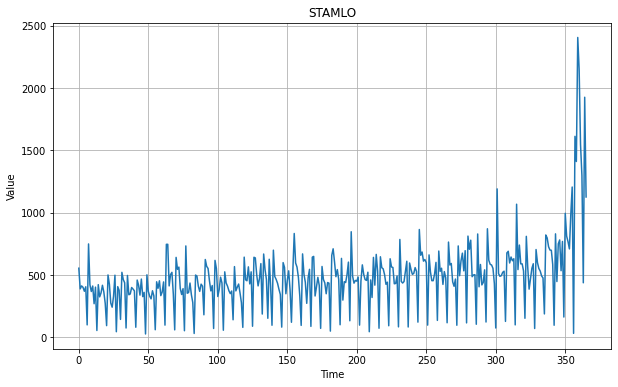

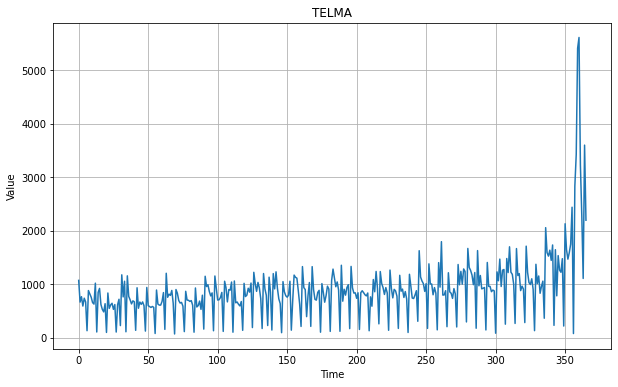

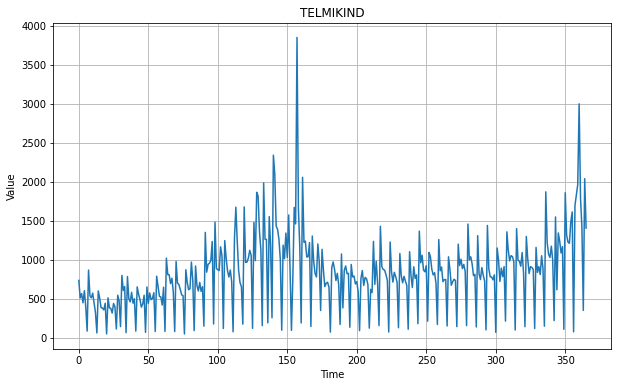

In [12]:
for i in dfs.keys():
    plt.figure(figsize=(10, 6))
    plot_series(time_dict[i], series_dict[i], i)
    plt.show()
    #plt.savefig(i + '.png')

In [13]:
z = iter(dfs.keys())

In [14]:
y = next(z); y

'ATEN'

In [15]:
time = time_dict[y]
series = series_dict[y]

In [16]:
split_time = 250
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
K.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 32
train_set = windowed_dataset(x_train, window_size, 4, 100)

model = Sequential()
model.add(InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16):
    model.add(
      Conv1D(filters=32,
              kernel_size=2,
              strides=1,
              dilation_rate=dilation_rate,
              padding="causal",
              activation="relu")
    )
model.add(Conv1D(filters=1, kernel_size=1))

lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
55/55 [==============================] - 14s 250ms/step - loss: 91.3443 - mae: 92.0386: 92.1273 - mae: 92.6
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 52.9219 - mae: 53.5105
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 44.0338 - mae: 44.5809
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 41.6556 - mae: 42.1664
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 40.1713 - mae: 40.7279
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 38.5978 - mae: 39.1687
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 37.0142 - mae: 37.5130
Epoch 8/100
55/55 [==============================] - 0s 4ms/step - loss: 34.1511 - mae: 34.5856
Epoch 9/100
55/55 [==============================] - 0s 4ms/step - loss: 32.3437 - mae: 32.8168
Epoch 10/100
55/55 [==============================] - 0s 4ms/step - loss: 32.0357 - mae: 32.5291
Epoch 11/100
55

55/55 [==============================] - 0s 4ms/step - loss: 60.3055 - mae: 60.8018
Epoch 86/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3663 - mae: 60.8249
Epoch 87/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3407 - mae: 60.8424
Epoch 88/100
55/55 [==============================] - 0s 4ms/step - loss: 60.4529 - mae: 60.8565
Epoch 89/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3413 - mae: 60.8427
Epoch 90/100
55/55 [==============================] - 0s 4ms/step - loss: 60.2881 - mae: 60.8372
Epoch 91/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3798 - mae: 60.8184
Epoch 92/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3184 - mae: 60.8587
Epoch 93/100
55/55 [==============================] - 0s 4ms/step - loss: 60.4517 - mae: 60.8959
Epoch 94/100
55/55 [==============================] - 0s 4ms/step - loss: 60.3975 - mae: 60.9143
Epoch 95/100
55/55 [=======================

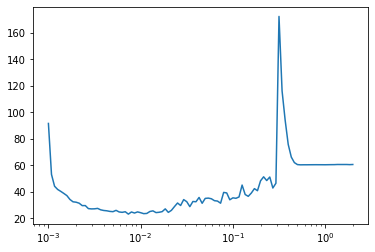

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-4, 1e-1, 0, 30])

In [21]:
K.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 32
train_set = windowed_dataset(x_train, window_size, 4, 100)
valid_set = windowed_dataset(x_valid, window_size, 4, 100)

model = Sequential()
model.add(InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16):
    model.add(
      Conv1D(filters=32,
              kernel_size=2,
              strides=1,
              dilation_rate=dilation_rate,
              padding="causal",
              activation="relu")
    )
model.add(Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=4e-3)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

model_checkpoint = ModelCheckpoint("model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=100)

history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
55/55 [==============================] - 2s 29ms/step - loss: 74.7138 - mae: 75.4008 - val_loss: 51.5001 - val_mae: 51.9979
Epoch 2/500
55/55 [==============================] - 0s 7ms/step - loss: 44.3011 - mae: 44.8279 - val_loss: 46.9319 - val_mae: 47.4288
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 40.7816 - mae: 41.3193 - val_loss: 47.2960 - val_mae: 47.7928
Epoch 4/500
55/55 [==============================] - 0s 6ms/step - loss: 38.0936 - mae: 38.5960 - val_loss: 46.7651 - val_mae: 47.2624
Epoch 5/500
55/55 [==============================] - 0s 6ms/step - loss: 36.0341 - mae: 36.5388 - val_loss: 44.2076 - val_mae: 44.7048
Epoch 6/500
55/55 [==============================] - 0s 6ms/step - loss: 34.1652 - mae: 34.7028 - val_loss: 48.7190 - val_mae: 49.2163
Epoch 7/500
55/55 [==============================] - 0s 6ms/step - loss: 33.0501 - mae: 33.5449 - val_loss: 44.8276 - val_mae: 45.3249
Epoch 8/500
55/55 [==============================] - 0

55/55 [==============================] - 0s 5ms/step - loss: 15.2342 - mae: 15.7464 - val_loss: 46.1941 - val_mae: 46.6920
Epoch 62/500
55/55 [==============================] - 0s 5ms/step - loss: 15.0593 - mae: 15.4958 - val_loss: 49.6759 - val_mae: 50.1742
Epoch 63/500
55/55 [==============================] - 0s 5ms/step - loss: 14.8776 - mae: 15.3648 - val_loss: 48.9996 - val_mae: 49.4981
Epoch 64/500
55/55 [==============================] - 0s 5ms/step - loss: 14.3161 - mae: 14.7430 - val_loss: 46.6044 - val_mae: 47.0999
Epoch 65/500
55/55 [==============================] - 0s 5ms/step - loss: 14.5655 - mae: 15.0424 - val_loss: 48.1196 - val_mae: 48.6182
Epoch 66/500
55/55 [==============================] - 0s 5ms/step - loss: 14.4043 - mae: 14.8607 - val_loss: 47.7949 - val_mae: 48.2907
Epoch 67/500
55/55 [==============================] - 0s 5ms/step - loss: 14.4702 - mae: 14.9718 - val_loss: 47.4131 - val_mae: 47.9099
Epoch 68/500
55/55 [==============================] - 0s 5ms/

In [115]:
model = load_model("model.h5")

In [116]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = forecast[split_time - window_size:-1, -1, 0]

Mean Absolute Error: 121.647736


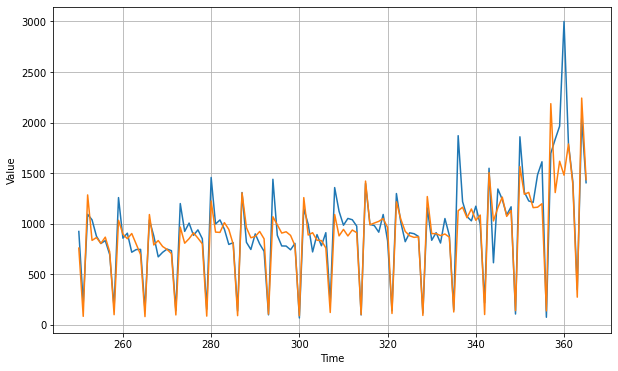

In [117]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)
print('Mean Absolute Error:', keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy())

In [118]:
forecasts = []
for i in range(window_size):
    x = int(round(model_forecast(model, series[-32:, np.newaxis], window_size)[0, -1, 0]))
    forecasts.append(x)
    series = np.append(series, x)

In [119]:
#drs = pd.DataFrame()
drs[y] = forecasts
drs

,ATEN,GLADOR,GLIMISAVE,GLUCONORM,S-NUMLO,STAMLO,TELMA,TELMIKIND
0,498,20,142,628,95,1373,3494,1401
1,527,27,133,480,84,1493,1303,1137
2,481,25,156,480,86,1234,2488,1297
3,372,29,110,391,66,1368,2993,1327
4,202,26,60,134,28,454,813,161
5,512,17,188,635,66,2112,4913,1786
6,490,27,146,399,47,1535,3644,1574
7,492,20,119,463,66,1286,3183,1352
8,466,24,135,407,39,1051,2462,1365
9,393,18,111,410,80,1168,2504,1508


In [121]:
drs.to_csv('forecast.csv', index=False)